# Load the Datasets

In [1]:
import os

folder_path = "E:/Gauava Disease Detection/Guava_Dataset/GuavaDiseaseDataset"
save_path = os.path.join(folder_path, "Saved_datasets")
train_num_shards = len(os.listdir(os.path.join(save_path, 'train')))
class_names = os.listdir(os.path.join(folder_path, "train"))

model_save_path = "E:/Gauava Disease Detection/Models/Saved_models"
os.makedirs(model_save_path, exist_ok=True)
model_path = os.path.join(model_save_path, "VGG16.keras")

RANDOM_SEED_1 = 42  # Used for random shuffling and sampling
RANDOM_SEED_2 = 101 # Used for other purposes

In [2]:
train_num_shards

5

In [3]:
class_names

['Anthracnose', 'fruit_fly', 'healthy_guava']

In [4]:
import tensorflow as tf

In [5]:
save_path_subdir = os.path.join(save_path, 'train')
shards = []
for i in range(train_num_shards):
    shard_path = os.path.join(save_path_subdir, f'shard_{i}')
    shard_dataset = tf.data.Dataset.load(shard_path, compression='GZIP')
    shards.append(shard_dataset)

train_ds = shards[0]
for shard in shards[1:]:
    train_ds = train_ds.concatenate(shard)

In [6]:
save_path_subdir = os.path.join(save_path, 'test')
test_ds = tf.data.Dataset.load(save_path_subdir, compression='GZIP')

In [7]:
save_path_subdir = os.path.join(save_path, 'val')
val_ds = tf.data.Dataset.load(save_path_subdir, compression='GZIP')

In [8]:
train_ds = (
    train_ds
        .cache()
        .shuffle(buffer_size=train_ds.cardinality(), seed=RANDOM_SEED_1)
        .prefetch(tf.data.AUTOTUNE)
)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [9]:
for ds in [train_ds, test_ds, val_ds]:
    print(ds)
    print("Cardinality: ", ds.cardinality().numpy(), "\n")

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
Cardinality:  83 

<_LoadDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
Cardinality:  12 

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
Cardinality:  24 



# VGG16 Model

## Model Training

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
input = Input(shape=(224, 224, 3), dtype="float32")
x = preprocess_input(input)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation="relu")(x)
x = Dense(3, activation='softmax')(x) # Output Layer

model = Model(inputs=input, outputs=x)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      8,224 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │         99 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,854,339 (56.66 MB)

 Trainable params: 139,651 (545.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [14]:
history = model.fit(
    x=train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=early_stopping,
    verbose=1
)

Epoch 1/20


83/83 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.8617 - loss: 0.3897 - val_accuracy: 0.9695 - val_loss: 0.1235
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 380s 5s/step - accuracy: 0.9756 - loss: 0.0671 - val_accuracy: 0.9762 - val_loss: 0.0481
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.9982 - loss: 0.0066 - val_accuracy: 0.9841 - val_loss: 0.0395
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 295s 4s/step - accuracy: 0.9992 - loss: 0.0057 - val_accuracy: 0.9868 - val_loss: 0.0362
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.9999 - loss: 0.0027 - val_accuracy: 0.9894 - val_loss: 0.0225
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 297s 4s/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9907 - val_loss: 0.0230
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 1.0000 - loss: 7.3017e-04 - val_accuracy: 0.9921 - val_loss: 0.0219
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 383s 5s/step - accuracy: 1.0000 - loss: 7.1234e-04 - val_accuracy: 0.9921 - val_

In [15]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


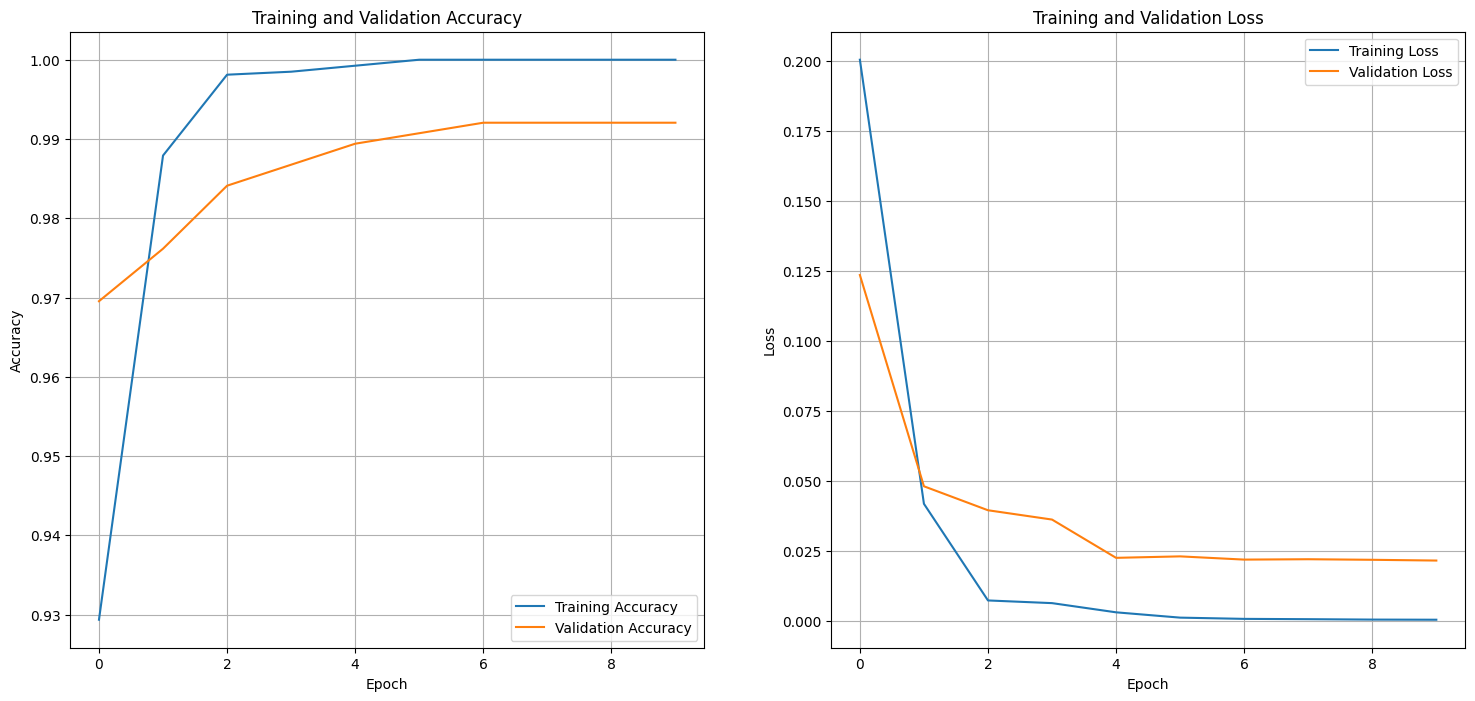

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']  
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a plot
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.show()

## Testing & Evaluation

In [17]:
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [18]:
# Assuming test_ds is preprocessed and batched
loss, accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.9816 - loss: 0.0659
Test Loss: 0.04283137992024422
Test Accuracy: 98.43%


In [19]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # If the output is one-hot encoded
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step


In [20]:
print(f"Accuracy: {accuracy_score(y_true_classes, y_pred_classes) * 100:.2f}% \n")
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Accuracy: 98.43% 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       156
           1       0.97      0.98      0.98       132
           2       0.98      0.97      0.97        94

    accuracy                           0.98       382
   macro avg       0.98      0.98      0.98       382
weighted avg       0.98      0.98      0.98       382



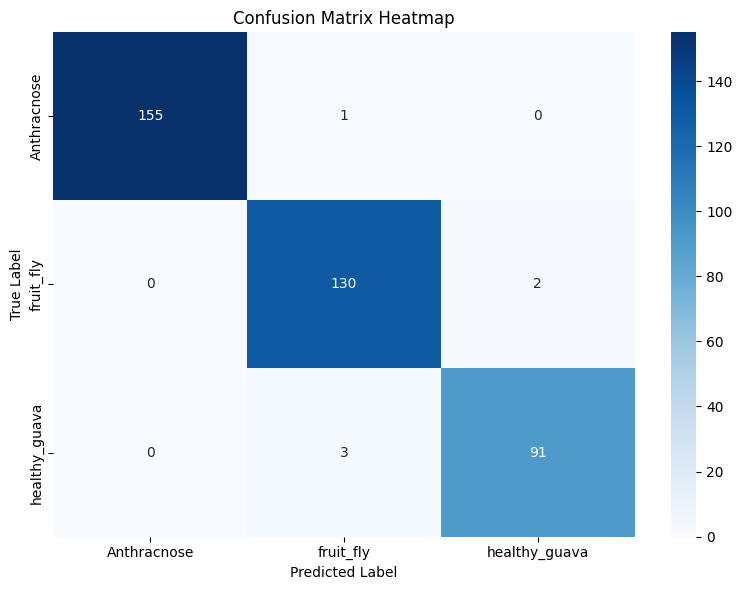

In [21]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels, title, and adjust layout
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

Max. accuracy attained is around `98%`

In [22]:
model.save(model_path)

# Sample Prediction

In [23]:
from tensorflow.keras.models import load_model

In [24]:
model = load_model(model_path)

In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      8,224 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │         99 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,133,643 (57.73 MB)

 Trainable params: 139,651 (545.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 279,304 (1.07 MB)

In [26]:
import random
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

E:/Gauava Disease Detection/Guava_Dataset/GuavaDiseaseDataset/test\Anthracnose\96_unsharp_clahe_augmented_5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
Predicted class index: [0]
Predicted class label: Anthracnose


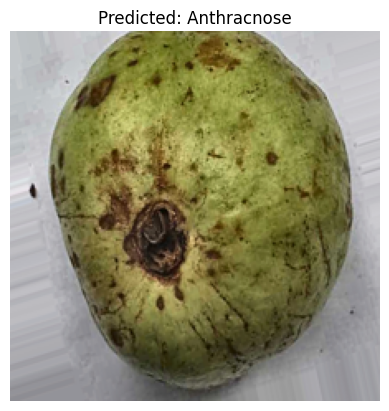

E:/Gauava Disease Detection/Guava_Dataset/GuavaDiseaseDataset/test\fruit_fly\70_unsharp_clahe_augmented_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Predicted class index: [1]
Predicted class label: fruit_fly


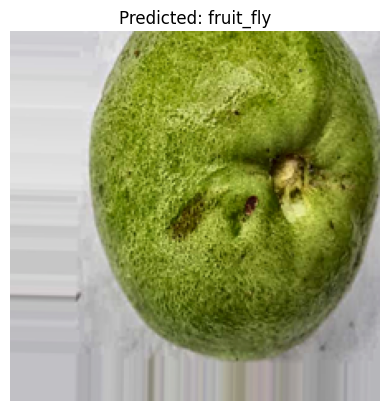

E:/Gauava Disease Detection/Guava_Dataset/GuavaDiseaseDataset/test\healthy_guava\17_unsharp_clahe_augmented_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
Predicted class index: [2]
Predicted class label: healthy_guava


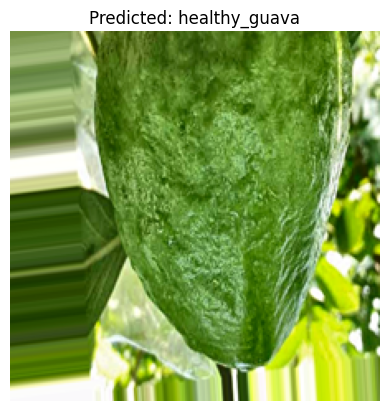

In [27]:
test_dir = "E:/Gauava Disease Detection/Guava_Dataset/GuavaDiseaseDataset/test"
test_subdirs = [os.path.join(test_dir, _) for _ in os.listdir(test_dir)]

for subdir in test_subdirs:
    images = os.listdir(subdir)
    n = len(images)
    pick_n = random.randint(0, n)
    picked_img_dir = os.path.join(subdir, images[pick_n])
    print(picked_img_dir)

    # Load and display the sample image
    img = Image.open(picked_img_dir)
    img.show()
    img_resized = img.resize((224, 224))  # Adjust to your model's input size
    img_array = np.expand_dims(img_resized, axis=0)  # Add batch dimension

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)  # Get the class index
    print(f"Predicted class index: {predicted_class}")
    print(f"Predicted class label: {class_names[predicted_class[0]]}")

    # Display the image with the predicted label
    plt.imshow(img_resized)
    plt.title(f"Predicted: {class_names[predicted_class[0]]}")
    plt.axis('off')
    plt.show()